In [42]:
import time
start0 = time.time()

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from collections import Counter
from sklearn.ensemble import VotingClassifier

upsample_flag = 1   #1: Minor class upsampled; 2: Major class downsampled; 3: Baseline dataset

num_cv = 3
random_state_ = 42
test_size_ = 0.65

%matplotlib inline
print('Dataset Value: {}' .format(upsample_flag))

Dataset Value: 1


Data for this project was obtained from IBM.

In [43]:
url = 'df_vect.csv'
df_raw = pd.read_csv(url)

In [44]:
df_raw.head()

,tenure,MonthlyCharges,TotalCharges,Churn,isFemale,hasPartner,hasDependents,hasPhoneService,hasMultipleLines,hasInternetService,hasOnlineSecurity,hasOnlineBackup,hasDeviceProtection,hasTechSupport,hasStreamingTV,hasStreamingMovies,hasContract,hasPaperlessBilling,hasAutoPaymentMethod
0,1,29.85,29.85,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0
1,34,56.95,1889.50,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0
2,2,53.85,108.15,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0
3,45,42.30,1840.75,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,1
4,2,70.70,151.65,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0


In [45]:
df = df_raw[['tenure', 'MonthlyCharges', 'hasInternetService', 'hasStreamingMovies', 'hasContract', 'Churn']]
df.head()


,tenure,MonthlyCharges,hasInternetService,hasStreamingMovies,hasContract,Churn
0,1,29.85,1,0,0,0
1,34,56.95,1,0,1,0
2,2,53.85,1,0,0,1
3,45,42.30,1,0,1,0
4,2,70.70,1,0,0,1


# Data up/down sampling

In [46]:
df_vect_major = df[df['Churn'] == 0]
df_vect_minor = df[df['Churn'] == 1]

In [47]:
df_vect_major.head()

,tenure,MonthlyCharges,hasInternetService,hasStreamingMovies,hasContract,Churn
0,1,29.85,1,0,0,0
1,34,56.95,1,0,1,0
3,45,42.30,1,0,1,0
6,22,89.10,1,0,0,0
7,10,29.75,1,0,0,0


In [48]:
df_vect_minor.head()

,tenure,MonthlyCharges,hasInternetService,hasStreamingMovies,hasContract,Churn
2,2,53.85,1,0,0,1
4,2,70.70,1,0,0,1
5,8,99.65,1,1,0,1
8,28,104.80,1,1,0,1
13,49,103.70,1,1,0,1


In [49]:
print("Major Class Shape: {}" .format(df_vect_major.shape))
print("Minor Class Shape: {}" .format(df_vect_minor.shape))

Major Class Shape: (5174, 6)
Minor Class Shape: (1869, 6)


In [50]:
df_minor_upsample = resample(df_vect_minor, replace=True, n_samples =5174, random_state=random_state_)

In [51]:
df_minor_upsample.shape

(5174, 6)

In [52]:
df_upsampled = pd.concat([df_vect_major, df_minor_upsample])

In [53]:
df_upsampled.shape

(10348, 6)

In [54]:
df_upsampled[df['Churn'] == 0].shape

(5174, 6)

In [55]:
df_upsampled[df['Churn'] == 1].shape

(5174, 6)

In [56]:
X = df_upsampled.drop('Churn', axis=1)
y = df_upsampled['Churn']

In [57]:
X.shape

(10348, 5)

In [58]:
y.shape

(10348,)

In [59]:
def learning_curves(model, X_training_data, y_training_data, model_name, num_k):
    '''
    This function creates testing and cross validation learning curves that can be used
    to assess the performance of a given model.
    
    Inputs:
    model: This is the model object being used. 
    X_training_data: This is the training data that is used for the model training.
    y_training_data: This is the actual response values for the training set.
    model_name: This is the name of the model, as a text string.
    num_k: This is the number of folks to use during the cross validation phase.
    '''
    plt.figure()

    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(model, X_training_data, y_training_data, cv=num_k)

    plt.title("Learning Curves: " + model_name + " With Standard Scaler")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")

    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="b")

    plt.plot(train_sizes, 
             train_scores_mean, 
             'o-', 
             color="r", 
             label="Training score")

    plt.plot(train_sizes, 
             test_scores_mean, 
             'o-', color="b", 
             label="Cross-validation score")

    plt.ylim([0.0, 1.25])
    plt.legend(loc="best")
    return plt.show()

In [60]:
def auc_roc_curves(model, X_test_data_, y_test_data_, model_name):
    
    roc_auc  = roc_auc_score(y_test_data_, model.predict(X_test_data_))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_data_)[:,1])
    
    plt.figure()

    plt.plot(fpr, tpr, label= model_name + ' (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: ' + model_name)
    plt.legend(loc="lower right")
    return plt.show()

# Data Scaling Using `StandardScaler`.

In [61]:
standard_scaler = StandardScaler()

In [62]:
print(standard_scaler.fit(X))
X_std = standard_scaler.transform(X)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [63]:
#https://chrisalbon.com/machine_learning/model_evaluation/split_data_into_training_and_test_sets/
#Tl;dr: Split the data set using train_test_split first then apply standard scaler. 

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size_, 
                                                    random_state=random_state_, 
                                                    shuffle=True, 
                                                    stratify=y)
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#This means that we don't need to run Stratified_Shuffle_Split.

In [65]:
print(standard_scaler.fit(X_train))
X_train_std_df = standard_scaler.transform(X_train)
X_test_std_df = standard_scaler.transform(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [66]:
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (3621, 5)
Shape of X_test: (6727, 5)
Shape of y_train: (3621,)
Shape of y_test: (6727,)


# Part 2: Model development and tuning using `XBGClassifier`.

In [67]:
#https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
#https://github.com/dmlc/xgboost/tree/master/demo/guide-python

#XGB base with standard scaler
xgb_model = XGBClassifier(random_state=random_state_)
xgb_model.fit(X_train_std_df, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [68]:
y_pred_prob = xgb_model.predict(X_test_std_df)
y_pred_class = xgb_model.predict(X_test_std_df)

In [69]:
print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.7648363865992194
---
Classification Report:
             precision    recall  f1-score   support

          0       0.80      0.71      0.75      3364
          1       0.74      0.82      0.78      3363

avg / total       0.77      0.76      0.76      6727

---
Confusion Matrix:
[[2390  974]
 [ 608 2755]]


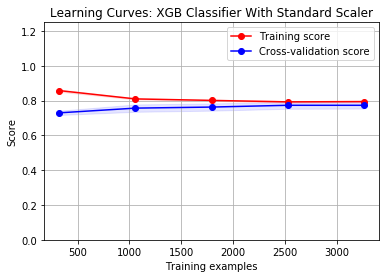

In [70]:
learning_curves(xgb_model, X_train_std_df, y_train, "XGB Classifier", 10)

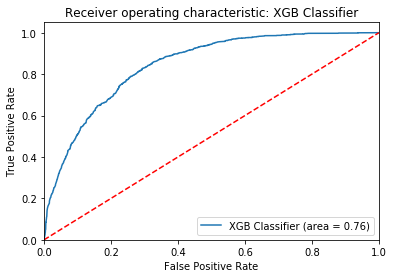

In [71]:
auc_roc_curves(xgb_model, X_test_std_df, y_test, 'XGB Classifier')

In [72]:
# https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
xgb_grid = XGBClassifier(random_state=random_state_)
learning_rate = [0.01, 0.1, 1]
max_depth = [1, 3, 5, 7]
n_estimators = [100, 1000]
hyperparameters = dict(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
grid_results = GridSearchCV(xgb_grid, 
                            hyperparameters, 
                            verbose=3, 
                            cv=3, 
                            scoring='recall').fit(X_train_std_df, y_train) #Will output the probability.

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] learning_rate=0.01, max_depth=1, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=100, score=0.8675496688741722, total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=100, score=0.8692052980132451, total=   0.0s
[CV] learning_rate=0.01, max_depth=1, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=100, score=0.8855721393034826, total=   0.0s
[CV] learning_rate=0.01, max_depth=1, n_estimators=1000 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=1000, score=0.8195364238410596, total=   0.3s
[CV] learning_rate=0.01, max_depth=1, n_estimators=1000 ..............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=1000, score=0.7897350993377483, total=   0.3s
[CV] learning_rate=0.01, max_depth=1, n_estimators=1000 ..............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=1000, score=0.8590381426202321, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, score=0.8211920529801324, total=   0.1s
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, score=0.7682119205298014, total=   0.1s
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, score=0.8076285240464345, total=   0.1s
[CV] learning_rate=0.01, max_depth=3, n_estimators=1000 ....

[CV]  learning_rate=1, max_depth=1, n_estimators=1000, score=0.7913907284768212, total=   0.3s
[CV] learning_rate=1, max_depth=1, n_estimators=1000 .................
[CV]  learning_rate=1, max_depth=1, n_estimators=1000, score=0.8308457711442786, total=   0.4s
[CV] learning_rate=1, max_depth=3, n_estimators=100 ..................
[CV]  learning_rate=1, max_depth=3, n_estimators=100, score=0.8178807947019867, total=   0.1s
[CV] learning_rate=1, max_depth=3, n_estimators=100 ..................
[CV]  learning_rate=1, max_depth=3, n_estimators=100, score=0.8096026490066225, total=   0.1s
[CV] learning_rate=1, max_depth=3, n_estimators=100 ..................
[CV]  learning_rate=1, max_depth=3, n_estimators=100, score=0.8175787728026535, total=   0.1s
[CV] learning_rate=1, max_depth=3, n_estimators=1000 .................
[CV]  learning_rate=1, max_depth=3, n_estimators=1000, score=0.8195364238410596, total=   0.7s
[CV] learning_rate=1, max_depth=3, n_estimators=1000 .................
[CV]  l

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   38.5s finished


In [73]:
print(grid_results.best_params_)

{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100}


In [74]:
print(grid_results.best_score_) #It is assumed that this combination will yield the best performing model.

0.8741040581888945


In [75]:
xgb_ = grid_results.best_estimator_
print(xgb_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


In [76]:
xgb_tuned = grid_results.best_estimator_

In [77]:
xgb_tuned.fit(X_train_std_df, y_train)
y_pred_class = xgb_tuned.predict(X_test_std_df)

In [78]:
print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.7273920254797698
---
Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.56      0.67      3364
          1       0.67      0.89      0.77      3363

avg / total       0.76      0.73      0.72      6727

---
Confusion Matrix:
[[1888 1476]
 [ 358 3005]]


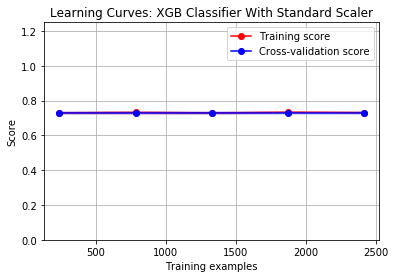

In [79]:
learning_curves(xgb_tuned, X_train_std_df, y_train, "XGB Classifier", 3)

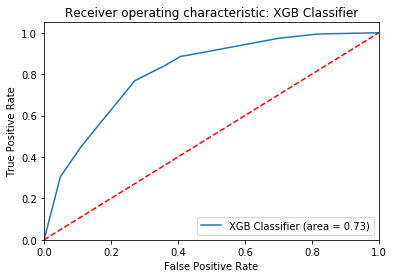

In [80]:
auc_roc_curves(xgb_tuned, X_test_std_df, y_test, 'XGB Classifier')

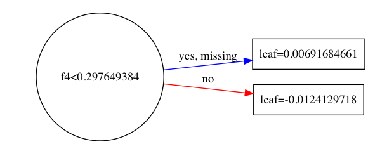

In [81]:
from xgboost import plot_tree
plot_tree(xgb_tuned, num_trees=4, rankdir='LR')
plt.show()

In [82]:
end0 = time.time()
print('Elapsed Time {}'.format(end0 - start0))

Elapsed Time 43.76379680633545
